Este notebook iré pegar os dados construídos no dataset 3 e irá fazer o processo de treino do modelo

# Setting up

In [32]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.pandas import merge_asof
from pyspark.pandas import DataFrame as ps
from pyspark.sql import Window

from pathlib import Path

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
import pickle
# current repo path 
repo_path = Path().resolve().parent

spark = SparkSession.builder.appName('Spark Demo').master('local[*]').getOrCreate()

In [2]:
df =spark.read.json((repo_path / 'data' / 'processed' / 'modelling_dataset').as_posix())

In [3]:
df.show(5)


25/05/16 15:18:22 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+----+--------------------+-----------------+--------------+--------+-----+--------------+------+---------+------+----------------+---------------+---------------+--------------------+-------------+---------------------+----------+-------------+--------------------+------------------+------+------+---------------------+---------------------+------------------+-----------------+----+---------------+
|          account_id| age|            channels|credit_card_limit|discount_value|duration|email|         event|gender|min_value|mobile|month_registered|num_past_offers|num_past_viewed|            offer_id|   offer_type|past_offer_conversion|qtd_canais|registered_on|   registered_on_cos|registered_on_seno|social|target|time_since_last_offer|time_since_test_start| total_past_amount|total_past_reward| web|year_registered|
+--------------------+----+--------------------+-----------------+--------------+--------+-----+--------------+------+---------+------+----------------+--

# Check correlations

Checking if columns has a high correlation with each other

In [4]:
columns_check = [
    "age",
    "credit_card_limit",
    "discount_value",
    "duration",
    "email",
    "min_value",
    "mobile",
    "num_past_offers",
    "num_past_viewed",
    'past_offer_conversion',
    'qtd_canais',
    'registered_on_cos',
    'registered_on_seno',
    'social',
    'target',
    'time_since_last_offer',
    'time_since_test_start',
    'total_past_amount',
    'total_past_reward',
    'web'
]

temp = df.select(columns_check).toPandas()

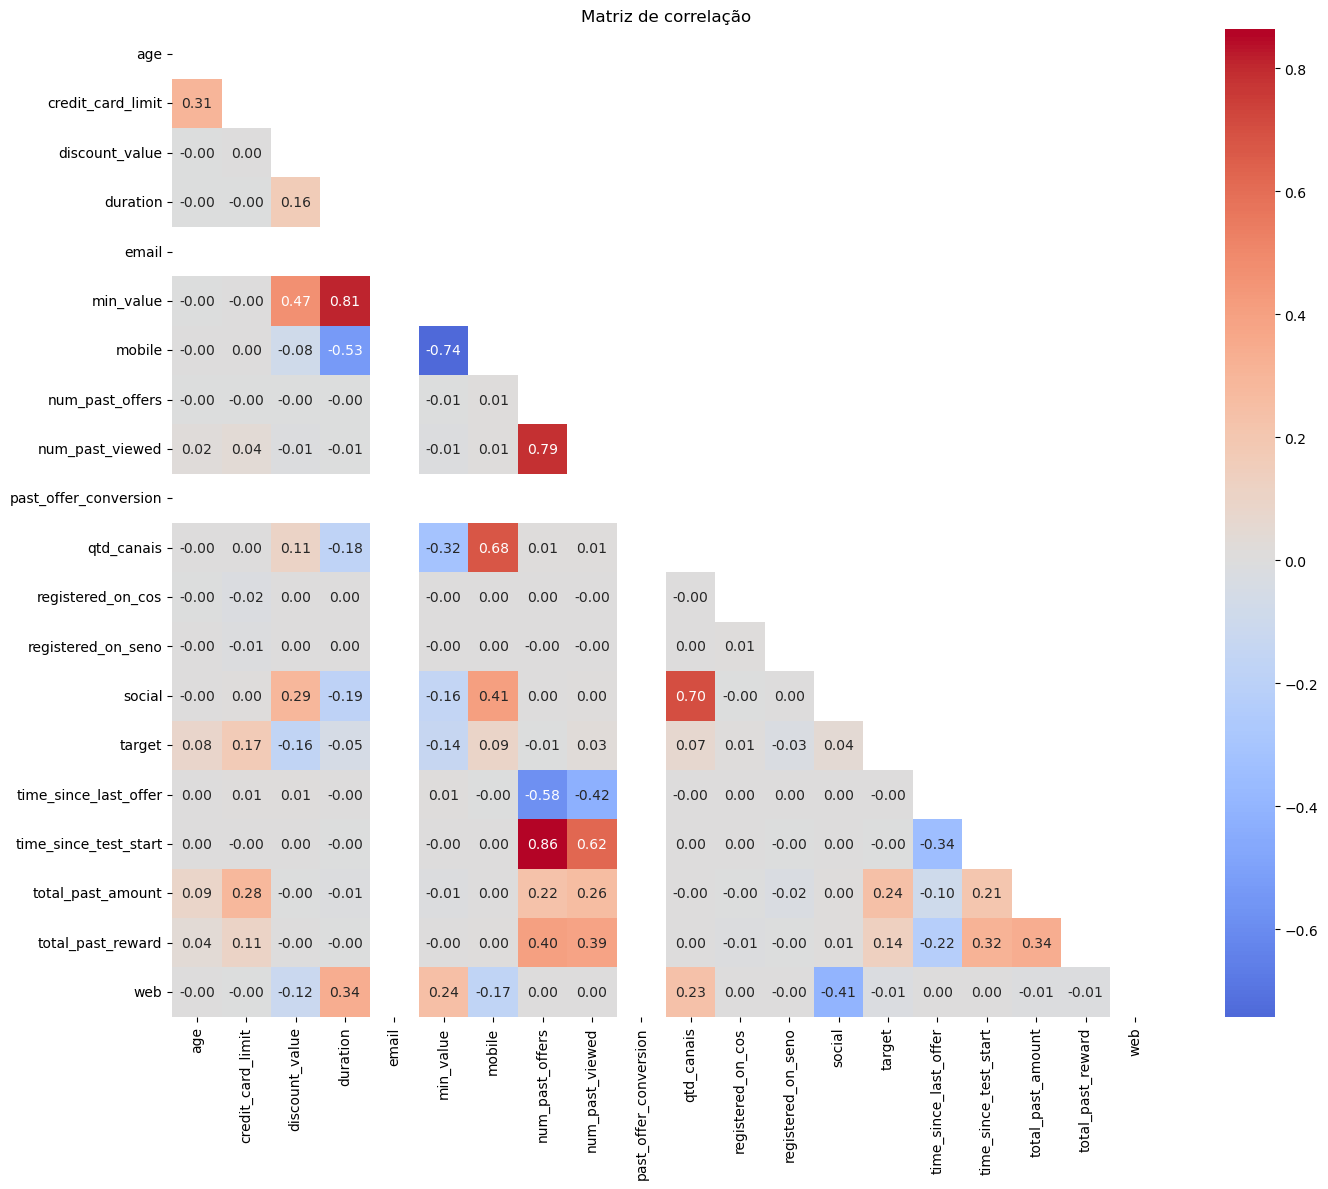

In [5]:
#matrix de correlação
corr_matrix = temp.corr()
plt.figure(figsize=(15,12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, 
            mask=mask,
            annot=True,
            cmap='coolwarm',
            center=0,
            fmt='.2f', 
            square=True) 

plt.title('Matriz de correlação')
plt.tight_layout() 
plt.show()


Temos algumas correlações interessantes entre as features e nenhuma extremamente alta exceto time_since_test_start (inicio daquela ofertapro customer) e o numro de ofertas passadas. Claramente isso deveria acontecer e irei considerar apenas a num_past_offers pra modelagem. O valor minimo da oferta com a duração também é alta, mas indicam coisas diferentes então as deixarei na modelagem.

Notemos também que aqui não usarmeos todas as features que estão salvas no dataset já que foram transformadas (exemplo: lista de canais)

# Modelagem

Irei treinar apenas dois modelos, uma regressão logistica como baseline e um LightGBM para ver as diferenças de métricas. Poderia treinar outros porém não vou gastar muito tempo apenas iterando sobre modelos para o case.

In [6]:
df = df.toPandas()

## Balanceamento

In [7]:
df['target'].value_counts(normalize=True)

target
1    0.598935
0    0.401065
Name: proportion, dtype: float64

Classes estão levemente desbalanceadas

## Train Test split

Iremos separar o dataset da seguinte maneira: pegando ultimas offers dos clientes como validação e o resto como treino

In [8]:
# pegando ultimas offers de cada
last_offers_idx = df.sort_values(['account_id', 'time_since_test_start'])\
                   .groupby('account_id').tail(1).index

# criando datasets
df_test = df.loc[last_offers_idx].copy()
df_train = df.drop(last_offers_idx).copy()

print(f"Proporção dos dois datasets: {len(df_test)/(len(df_test)+len(df_train)):.5f}")


Proporção dos dois datasets: 0.22279


Mantemos uma boa proporção entre os dois datasets dessa maneira

In [9]:
X_train = df_train.drop(columns=['target'])
y_train = df_train['target']
X_test = df_test.drop(columns=['target'])
y_test = df_test['target']


Como separamos temporalmente, vamos ver se a ainda temos um numero consideravel entre as targets no test set

In [10]:
y_test.value_counts(normalize=True)

target
1    0.587443
0    0.412557
Name: proportion, dtype: float64

Ótimo

## Pipeline

Agora criando pipeline completo

In [11]:
# Criando transformers que serão usadas no modelo

simplescaler_features = [
    "discount_value",
    "duration",
    "email",
    "min_value",
    "mobile",
    "qtd_canais",
    "registered_on_cos",
    "registered_on_seno",
    "social",
    "web",
]
simplescaler_transformer = Pipeline(steps=[("scaler", StandardScaler())])


numeric_median_features = ["age", "credit_card_limit"]
numeric_median_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

numeric_0_features = [
    "num_past_viewed",
    "past_offer_conversion",
    "total_past_amount",
    "total_past_reward",
]
numeric_0_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
        ("scaler", StandardScaler()),
    ]
)

numeric_1_features = ["time_since_last_offer"]
numeric_1_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value=-1)),
        ("scaler", StandardScaler()),
    ]
)

categorical_features = ["gender", "offer_type", "year_registered", "month_registered"]
categorical_transformer = Pipeline(
    steps=[
        (
            "encoder",
            OneHotEncoder(handle_unknown="infrequent_if_exist", sparse_output=False),
        ),
        # ("selector", SelectPercentile(chi2, percentile=50)),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num_median", numeric_median_transformer, numeric_median_features),
        ("num_0", numeric_0_transformer, numeric_0_features),
        ("num_1", numeric_1_transformer, numeric_1_features),
        ("cat", categorical_transformer, categorical_features),
        ("simplescaler", simplescaler_transformer, simplescaler_features),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
)

## Escolha da métrica

Aqui na classificação binária temos algumas opções de métricas a serem definidas:

 - Precision: indica de todos clientes que meu modelo que compraria uma offer X, quantos de fato compraram? O modelo otimiza que quando ele diz que um cliente irá converter, ele realmente tem alta chance de converter. É importante no caso de o custo de falso positivos ser alto (alguém que o modelo indica que converteria mas não converte).
 - Recall: indica de todos clientes que compraram a offer X, quantos o modelo identificou corretamente? É importante no caso de falso negativos (o custo de perder uma compra é alto).
 - Accuracy: Quantos das pessoas (que converteram e que não converteram) meu modelo classificou corretamente? 
 - F1-Score: é uma média harmônica entre precision e recall, tentando achar um equilíbrio entre os dois. Geralmente usada quando queremos minimizar falso positivos e falso negativos, não tendo que priorizar um à antemão do outro (o custo de um perder uma compra é igual ao de enviar offer a alguém não comprante.)
 - ROC-AUC: indica o quão bom o modelo é bom distinguir clientes que compram e que não compram, ara diversos thresholds de decisão. 
 - Log-Loss : usualmente usado para penalizar predições incorretas. 
 

 Aqui, como não sei a diferença de custo entre um falso positivo e um falso negativo para o negócio, irei otimizar a F1 na modelagem. Poderia também tentar accuracy já que o dataset está balanceado ou a AUC.


## Logistic Regression - Hyperparameter tuning

In [12]:
# Define parameter distributions for random search
param_distributions = {
    "classifier__C": scipy.stats.loguniform(1e-3, 2),
}

clf = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "classifier",
            LogisticRegression(
                class_weight="balanced", random_state=42
            ),
        ),
    ]
)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    clf,
    param_distributions=param_distributions,
    n_iter=200,
    cv=5,
    scoring="f1",
    n_jobs=-1,
    random_state=42,
    verbose=1,
)

# Fit random search
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num_median',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['age',
                                                                                'credit_card_limit']),
                                                                              ('num_0',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(fill_value=0,
                                                                                                              strategy='constant')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['n...
                                                                                'qtd_canais',
                                                                                'registered_on_cos',
                                                                                'registered_on_seno',
                                                                                'social',
                                                                                'web'])],
                                                                verbose_feature_names_out=False)),
                                             ('classifier',
                                              LogisticRegression(class_weight='balanced',
                                                                 random_state=42))]),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'classifier__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fc4817c45f0>},
                   random_state=42, scoring='f1', verbose=1)

### Metrics

In [13]:

print("Best parameters:", random_search.best_params_)
print("Best score: {:.3f}".format(random_search.best_score_))

best_model = random_search.best_estimator_

Best parameters: {'classifier__C': 0.7872696728245764}
Best score: 0.752


O modelo tem um F1 de 0.8, geralmente considerado bom. Iremos ver as outras métricas.

In [14]:
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

y_train_proba = best_model.predict_proba(X_train)[:,1]
y_test_proba = best_model.predict_proba(X_test)[:,1]

train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_roc_auc = roc_auc_score(y_train, y_train_proba)

test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_proba)

metrics_df = pd.DataFrame({
    'Train': [train_precision, train_recall, train_f1, train_accuracy, train_roc_auc],
    'Test': [test_precision, test_recall, test_f1, test_accuracy, test_roc_auc]
}, index=['Precision', 'Recall', 'F1', 'Accuracy', 'ROC AUC'])

print("\nModel Performance Metrics:")
print(metrics_df.round(3))



Model Performance Metrics:
           Train   Test
Precision  0.800  0.780
Recall     0.711  0.790
F1         0.753  0.785
Accuracy   0.719  0.746
ROC AUC    0.791  0.801


O modelo tem boas métricas

### Feature importance

In [17]:
feature_names = best_model[0].get_feature_names_out()

coefficients = best_model.named_steps['classifier'].coef_[0]

feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': coefficients 
})

feature_importances['std'] = np.std(best_model.named_steps['preprocessor'].transform(X_train),0)
feature_importances['importance'] = feature_importances['std'] * feature_importances['Importance']
feature_importances['color'] = np.where(feature_importances['importance'] > 0, 'blue', 'red')

<Axes: xlabel='Feature'>

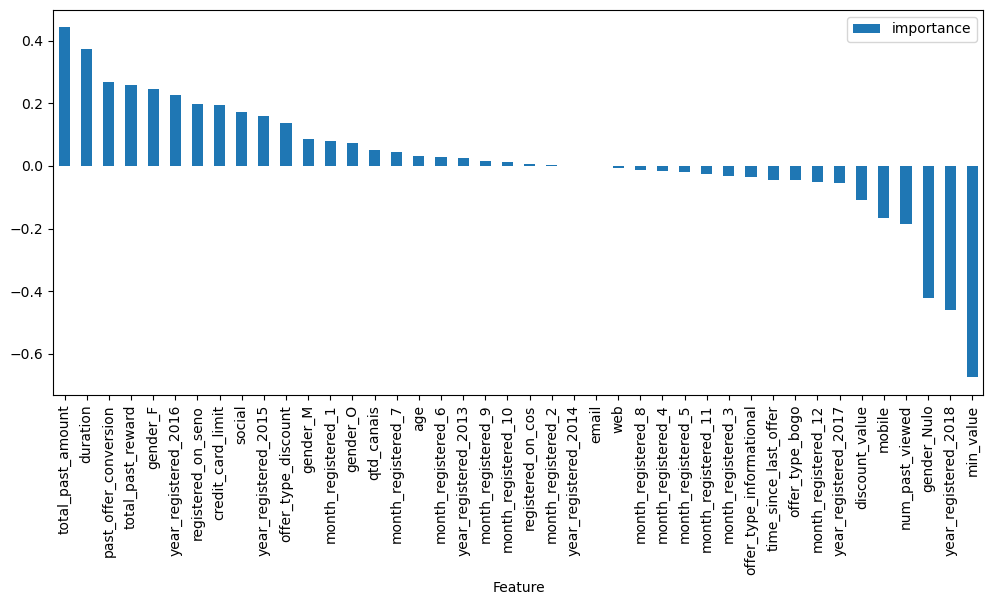

In [21]:
feature_importances.set_index("Feature")[["importance"]].sort_values(
    "importance", ascending=False
).plot(kind="bar", figsize=(12, 5))

<Axes: xlabel='Feature'>

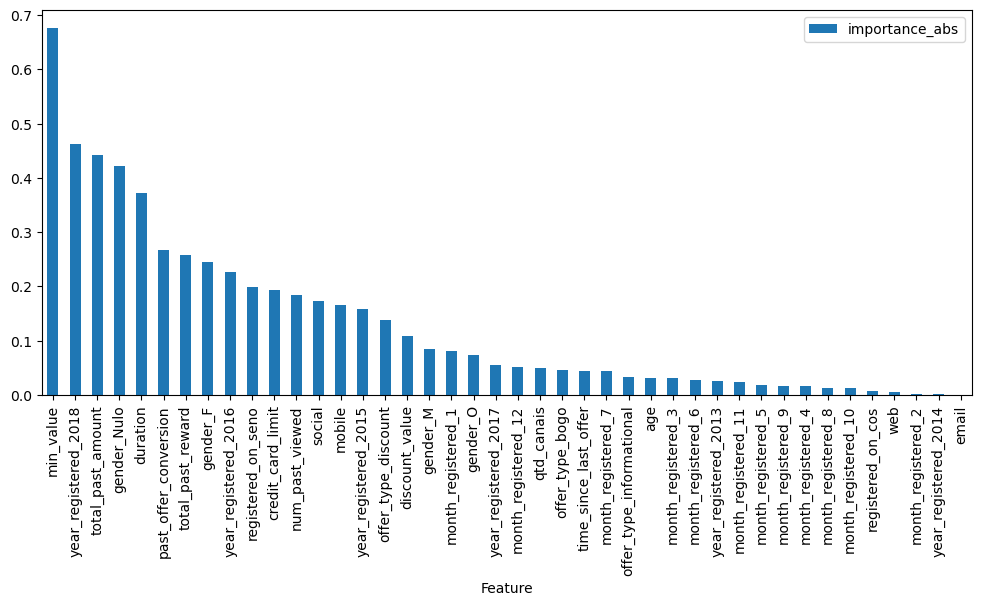

In [20]:
feature_importances.assign(
    importance_abs=feature_importances["importance"].abs()
).set_index("Feature")[["importance_abs"]].sort_values(
    "importance_abs", ascending=False
).plot(
    kind="bar", figsize=(12, 5)
)

## Boosting algorithm

In [27]:
# Define parameter distributions for random search
param_distributions = {
    "classifier__max_leaf_nodes": scipy.stats.randint(2, 200),
    "classifier__max_depth": scipy.stats.randint(2, 10),
    "classifier__l2_regularization": scipy.stats.loguniform(1e-3, 1),
}

clf = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", HistGradientBoostingClassifier(class_weight="balanced")),
    ]
)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    clf,
    param_distributions=param_distributions,
    n_iter=100,
    cv=5,
    scoring="f1",
    n_jobs=-1,
    random_state=42,
    verbose=1,
)

# Fit random search
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num_median',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['age',
                                                                                'credit_card_limit']),
                                                                              ('num_0',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(fill_value=0,
                                                                                                              strategy='constant')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['n...
                   param_distributions={'classifier__l2_regularization': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fc481191880>,
                                        'classifier__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fc3db3ca870>,
                                        'classifier__max_leaf_nodes': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fc481190a70>},
                   random_state=42, scoring='f1', verbose=1)

### Metrics

In [28]:
print("Best parameters:", random_search.best_params_)
print("Best score: {:.3f}".format(random_search.best_score_))

best_model = random_search.best_estimator_

Best parameters: {'classifier__l2_regularization': 0.003439284699685042, 'classifier__max_depth': 9, 'classifier__max_leaf_nodes': 129}
Best score: 0.797


In [30]:
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

y_train_proba = best_model.predict_proba(X_train)[:,1]
y_test_proba = best_model.predict_proba(X_test)[:,1]

train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_roc_auc = roc_auc_score(y_train, y_train_proba)

test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_proba)

metrics_df = pd.DataFrame({
    'Train': [train_precision, train_recall, train_f1, train_accuracy, train_roc_auc],
    'Test': [test_precision, test_recall, test_f1, test_accuracy, test_roc_auc]
}, index=['Precision', 'Recall', 'F1', 'Accuracy', 'ROC AUC'])

print("\nModel Performance Metrics:")
print(metrics_df.round(3))



Model Performance Metrics:
           Train   Test
Precision  0.862  0.780
Recall     0.818  0.859
F1         0.840  0.818
Accuracy   0.812  0.775
ROC AUC    0.897  0.836


Comparado com a logistica, o HistGradientBoostingClassifier performa bem melhor, iremos usar ele

### Feature importance

Aqui o modelonao disponibiliza feature importances. Teríamos que rodar um SHAP para o modelo, porém como isso é custoso de tempo irei passar essa parte.

## Saving

In [ ]:
(repo_path / 'serializables').mkdir(parents=True, exist_ok=True)

# salvaldo
with open((repo_path / 'serializables' / 'best_model.pkl').as_posix(), 'wb') as f:
    pickle.dump(best_model, f)